 - combinar las tablas
 - limpiar datos
 - combinar las columnas title, brand, summary, description en una nueva columna
 - tokenizar la nueva columnas combinada
 - calcular similitud con la similitud de los items tokenizados del coseno
 - los que son muy similares los eliminamos de la lista
 - agarramos algunos items de la lista y calculamos el mean del overall
 - ordenamos nuevamente descendentemente pero esta vez basados en el overall mean => lista2
 - recomendamos los 10 primeros de la lista 2



In [5]:
import nltk
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(PATH)

In [9]:
PATH = 'C:/Users/coraj/Documents/fuzzy-recommendation-system-/meta_AMAZON_FASHION.json.gz'

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_meta = getDF(PATH)

,title,brand,feature,rank,date,asin,imageURL,imageURLHighRes,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,XCC Qi promise new spider snake preparing men'...,NaN,NaN,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Magical Things I Really Do Do Too!,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,[For the professional or amateur magician. Ro...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Ashes to Ashes, Oranges to Oranges",Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aether & Empire #1 - 2016 First Printing Comic...,NaN,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN,$4.50,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_meta.shape

(186637, 16)

In [11]:
df_meta['asin'].nunique()

186194

notamos que hay productos que no son unicos, arreglamos eso

In [12]:
df_meta= df_meta.drop_duplicates(subset='asin', keep='first')
df_meta.shape

(186194, 16)

creamos una nueva columnas que contiene la informacion que necesitamos para encontrar items similares

In [15]:
columns_to_combine = ['title', 'brand', 'summary', 'description', 'expliota']
existing_columns = [col for col in columns_to_combine if col in df_meta.columns]

if existing_columns:
    # Al menos una de las columnas en 'existing_columns' existe en el df_metaFrame 'df_meta'.
    # Puedes combinar las columnas existentes y crear la nueva columna 'combined_text'.
    df_meta['combined_text'] = df_meta[existing_columns].apply(lambda row: ' '.join(str(val) for val in row), axis=1)

Text(0, 0.5, 'Count')

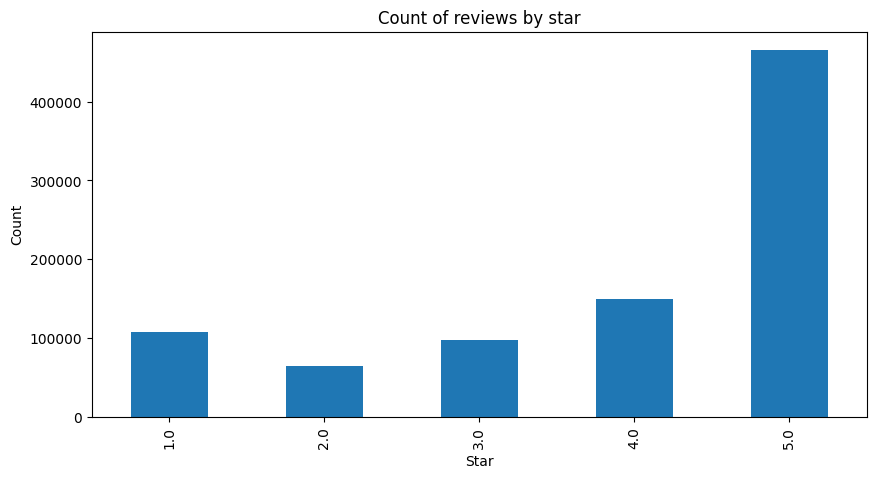

In [17]:
ax = df['overall'].value_counts().sort_index().plot(kind='bar', title="Count of reviews by star",figsize=(10, 5))
ax.set_xlabel("Star")
ax.set_ylabel("Count")


notamos que los reviews estan sesgados hacia 5 estrellas

calculamos el promedio de estrellas por producto y creamos una nueva columna en el df_metaFrame 'df_meta' para almacenar el promedio de estrellas por producto.

In [47]:
# Calcular el "rating score" promedio por 'asin'
rating_score = df.groupby('asin')['overall'].mean().reset_index()

# Renombrar la columna resultante como 'rating_score'
rating_score.rename(columns={'overall': 'rating_score'}, inplace=True)

# Fusionar el DataFrame original con el "rating score" usando 'asin' como clave
df = df.merge(rating_score, on='asin', how='left')

### Tokenizacion de comentarios

In [18]:
example = df['reviewText'][39]
example

'Excellent product!'

In [19]:
nltk.download('punkt')
tokens = nltk.word_tokenize(example)
tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['Excellent', 'product', '!']

In [20]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\coraj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [21]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Excellent', 'JJ'), ('product', 'NN'), ('!', '.')]

In [22]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Excellent/JJ product/NN !/.)


In [24]:
overall_mean = df.groupby('asin')['overall'].mean().sort_values(ascending=False)
overall_mean
# num_asin_values = df_meta['asin'].nunique()
# num_asin_values

asin
0764443682    5.0
B00Y88IVK6    5.0
B00Y8MUW7M    5.0
B00Y8LF6S8    5.0
B00Y8FXRX0    5.0
             ... 
B0105EWJWC    1.0
B01DK76L5M    1.0
B01DK76L52    1.0
B01DK76L2A    1.0
B010WGHX8S    1.0
Name: overall, Length: 186189, dtype: float64

In [25]:
# tokenized_rows = []
# for row in df_meta['combined_text']:
#     data_tokens = nltk.word_tokenize(row)
#     pos_tag = nltk.pos_tag(data_tokens)
#     ne_chunk = nltk.chunk.ne_chunk(pos_tag)
#     tokenized_rows.append(ne_chunk)
# df_meta['tokenized_combined_text'] = tokenized_rows
    

In [26]:
# df_meta['tokenized_combined_text'][0].pprint()

In [36]:
df_meta['id']=[i for i in range(0,df_meta.shape[0])]

In [37]:
df_meta_cortado = df_meta.head(1000)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()


In [38]:
vecs = vec.fit_transform(df_meta_cortado['combined_text'].apply(lambda x: np.str_(x)))
vecs.shape

(1000, 4729)

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
sim = cosine_similarity(vecs)

In [45]:
def recommend(asin):
    item_id = df_meta_cortado[df_meta_cortado.asin == asin]['id'].values[0]
    scores = list(enumerate(sim[item_id]))
    print(scores)
    sorted_scores= sorted(scores, key=lambda x:x[1], reverse=True)
    print(sorted_scores)
    sorted_scores=sorted_scores[1:]
    print(sorted_scores)
    items_selected=[df_meta_cortado[items_selected[0]==df_meta_cortado['id']]['title'].values[0] for items_selected in sorted_scores]
    return items_selected

In [46]:
temp = recommend('B00007GDFV')
temp

[(0, 0.017619149770934046), (1, 0.0), (2, 0.03516900936374405), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.012087620336459465), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.018660580037556468), (12, 0.01491751718359407), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.01940673952998887), (18, 0.04371600440556275), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.02101833333959963), (26, 0.020520194417129867), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.0), (42, 0.0), (43, 0.044613588339257985), (44, 0.0), (45, 0.006645331372951333), (46, 0.05203187585602463), (47, 0.0), (48, 0.023066841116063684), (49, 0.0), (50, 0.0), (51, 0.0), (52, 0.0), (53, 0.0), (54, 0.0), (55, 0.01944666319909365), (56, 0.07329486274409881), (57, 0.0), (58, 0.023462597461569798), (59, 0.02835353737049288), (60, 0.0), (61, 0.0), (62, 0.0), (63, 0.0), (64, 0.0), (65, 0.0), (66

['Buxton Micro-Fiber Organizer Mini Bag (Black )',
 'Buxton Mountaineer Executive Thinfold® (Brown)',
 'Triominos Pocket',
 'University of Kansas Shorts',
 '6-Piece Grow With Me Value Pack! - Blue',
 '6-Piece Grow With Me Value Pack! - Pink',
 'Lightweight Big & Tall Pocket T-Shirt',
 'Lightweight Big & Tall Pocket T-Shirt',
 'Lightweight Big & Tall Pocket T-Shirt',
 'Embassy Solid Genuine Suede Shoulder Bag',
 'Multi-Pocket Expandable Wheel Pack in Grey',
 'Avalon Magnifying Glass Pocket Watch A-1405',
 'Hanes Adult High Stitch Ring Spun Preshrunk Pocket T-Shirt',
 "Dopp Men's First Class Leather Seasoned Traveler Admiral Kit",
 'BLAZE black cow leather with zipper 14',
 'Del Mano Double Pocket Nylon Tote (Black)',
 'Blue Silk Brocade Handbag',
 'Raika Floral 4 x 6 Photo Album (Floral)',
 'Hold-Up X-Back Clip Suspenders',
 'Peony Pink Tie For Boys',
 'Embassy by Giovanni Navarre 3pc Italian Stone Design Genuine Leather Travel/Make-up Bag Set',
 'Lady Warm-up Jacket',
 'Converse Infant

In [ ]:
def recommend_ten(movie_list):
    first_ten = []
    for movie in movie_list:
        


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()